# Assignment 2: Text Classification with Convolutional Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Convolutional Neural Networks, and BERT-based models. In part two, you should be able to develop an intuition for:


*   The effects of fine-tuning word vectors and over fitting the model
*   How various hyperparameters can help or hurt overfitting




The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

This notebook uses the Keras 3 functional API.  Make sure the correct versions get loaded.




## IMPORTANT NOTE:
Because of the environment built in to Colab, the software we're importing causes an error to be thrown the first time you run the cells in the Setup section.  As soon as you hit the error, you have to go to the Runtime menu and select 'Restart Session'.  Once the session is restarted you must rerun the cells in Setup and you will not run in to the error.

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Fix Convolutional Neural Net (CNN) Over Fitting](#modelCNN)


  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-fall-main/blob/master/assignment/a2/Text_classification_CNN.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally in your Colab environment.


In [ ]:
!pip install gensim --quiet

In [2]:
!pip install tensorflow-datasets --quiet

In [ ]:
!pip install -U tensorflow-text --quiet

In [ ]:
!pip install pydot --quiet

In [ ]:
!pip install numpy<2.0


/bin/bash: line 1: 2.0: No such file or directory


Ready to do the imports.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [ ]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from nltk.

In [ ]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [ ]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [ ]:
vec_model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

We can now build the embedding matrix and a vocabulary dictionary:

In [ ]:
EMBEDDING_DIM = len(vec_model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(vec_model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(vec_model.index_to_key):
    embedding_vector = vec_model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [ ]:
embedding_matrix.shape

(43982, 300)

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [ ]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.3IT2O1_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.3IT2O1_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.3IT2O1_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [ ]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [ ]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

Next, we tokenize the data:

In [ ]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [ ]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [ ]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [ ]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [ ]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [ ]:
train_input[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958,  5589,  8092, 43981, 34516, 43981,  8092, 16182, 43981,
        39933, 43981, 12139,  2326, 32781, 32467,  7046, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [ ]:
train_labels[:4]

array([0, 0, 0, 1])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling




<a id = 'modelCNN'></a>
### 3.1 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [ ]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [ ]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 300)  │ 13,194,600 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 100)  │     90,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 100)  │    120,100 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 124, 50)   │     75,050 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 119, 25)   │     75,025 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 100)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 50)        │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 25)        │          0 │ conv1d_3[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 275)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 275)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │     27,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      5,050 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         51 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,587,576 (51.83 MB)

 Trainable params: 392,976 (1.50 MB)

 Non-trainable params: 13,194,600 (50.33 MB)

The keras plot utility shows this probably a bit nicer:

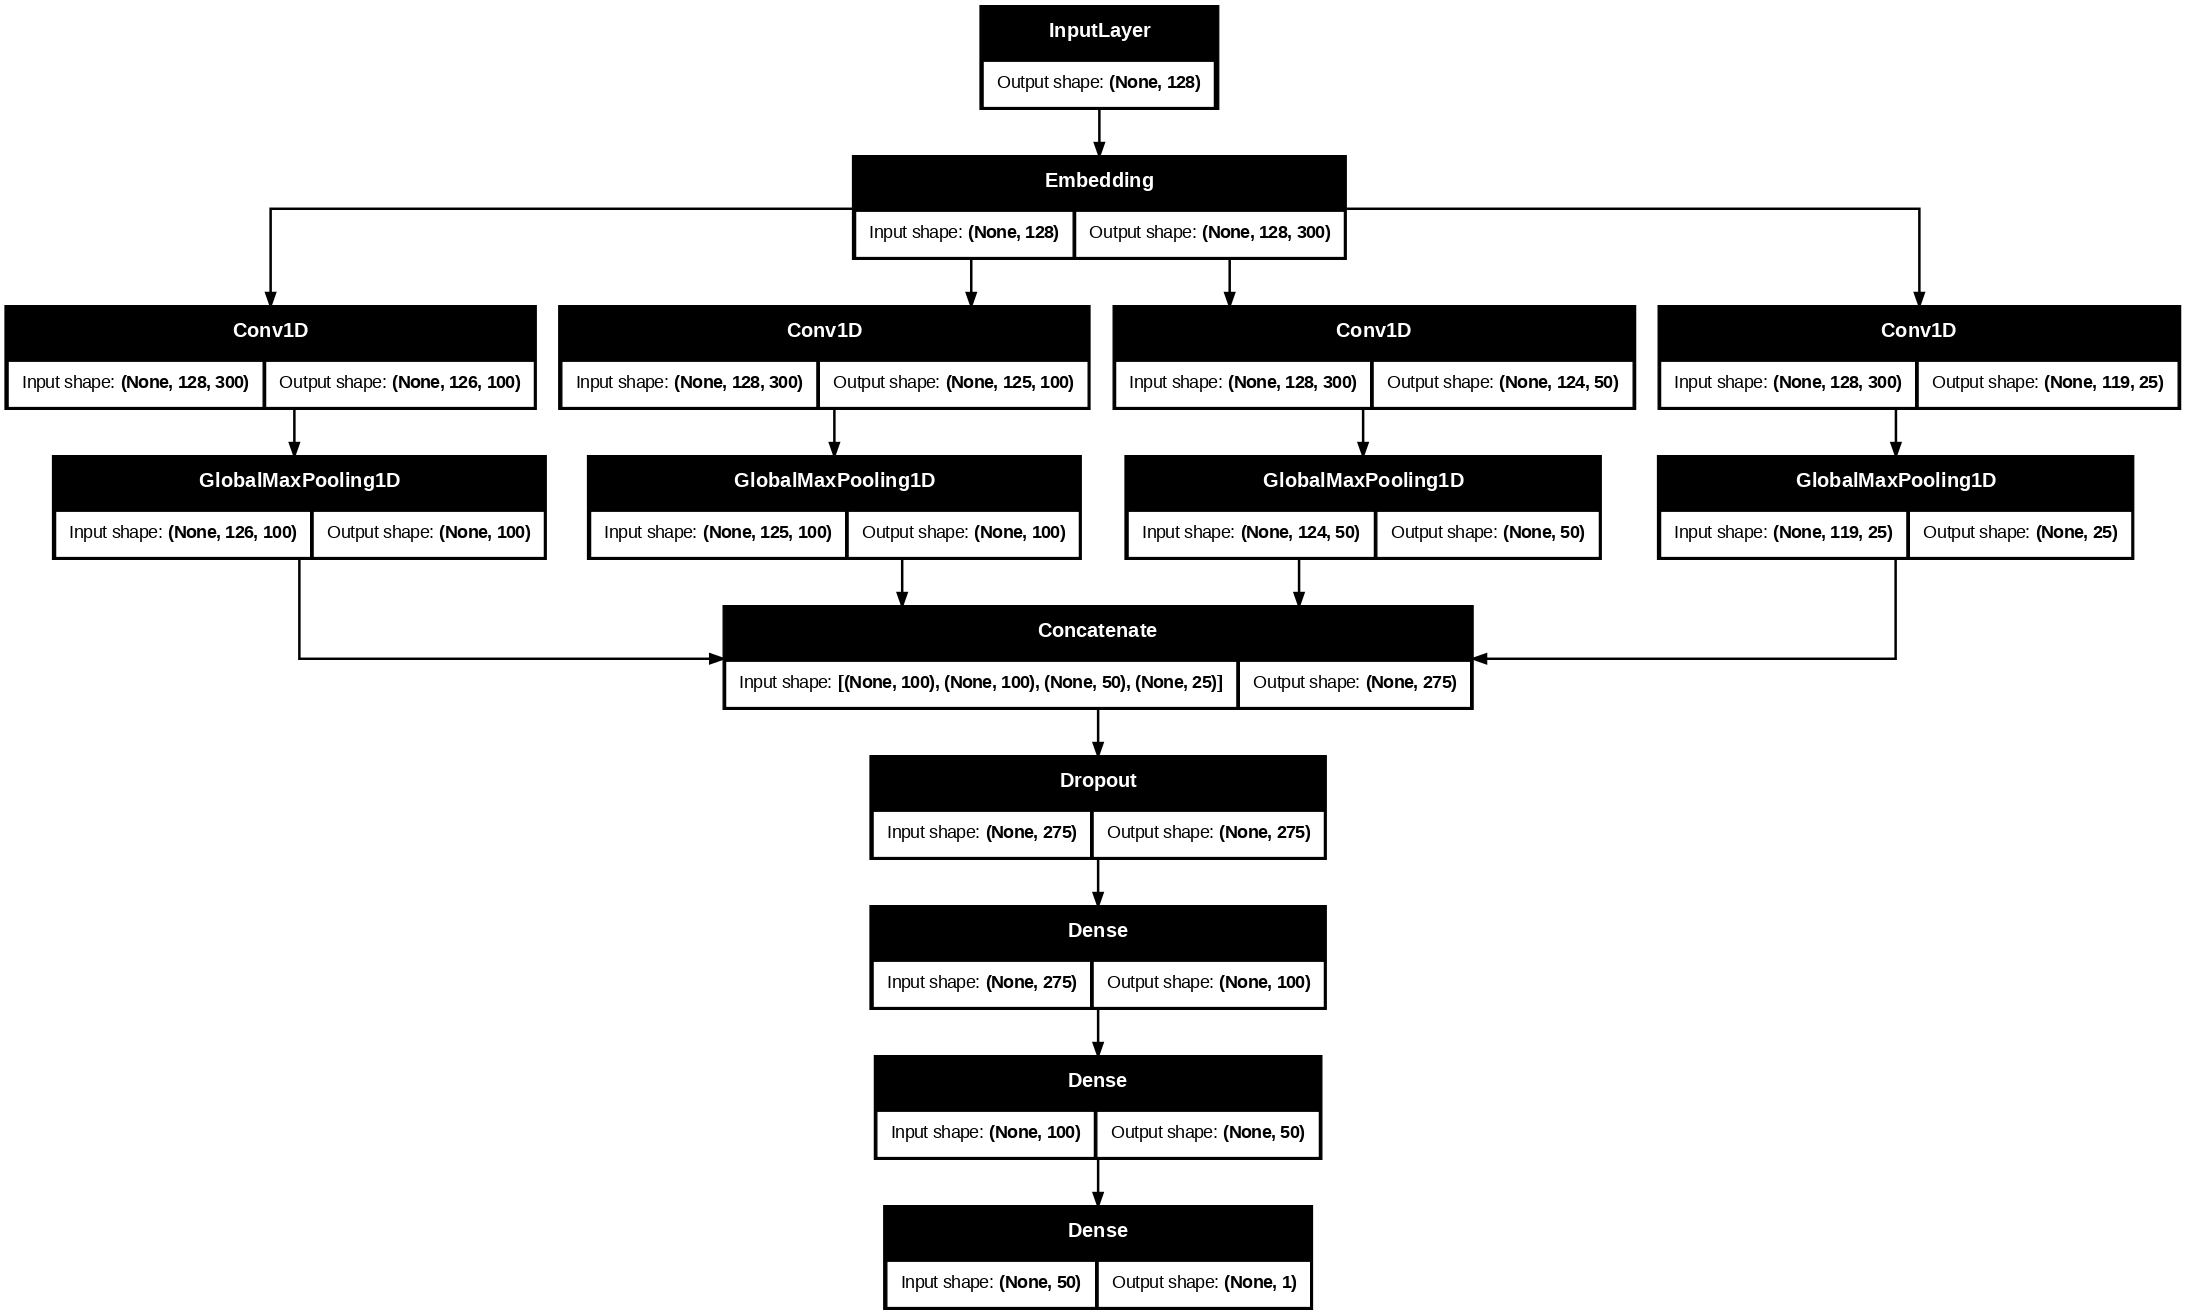

In [ ]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

Now let's train our CNN and see if it can learn without overfitting or underfitting.

In [ ]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 222ms/step - accuracy: 0.6275 - loss: 0.6221 - val_accuracy: 0.7956 - val_loss: 0.4439
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 201ms/step - accuracy: 0.8022 - loss: 0.4302 - val_accuracy: 0.8080 - val_loss: 0.4126
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 136s 218ms/step - accuracy: 0.8422 - loss: 0.3613 - val_accuracy: 0.8176 - val_loss: 0.3969
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 215ms/step - accuracy: 0.8689 - loss: 0.3155 - val_accuracy: 0.8080 - val_loss: 0.4136
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 202ms/step - accuracy: 0.8919 - loss: 0.2674 - val_accuracy: 0.8236 - val_loss: 0.4044


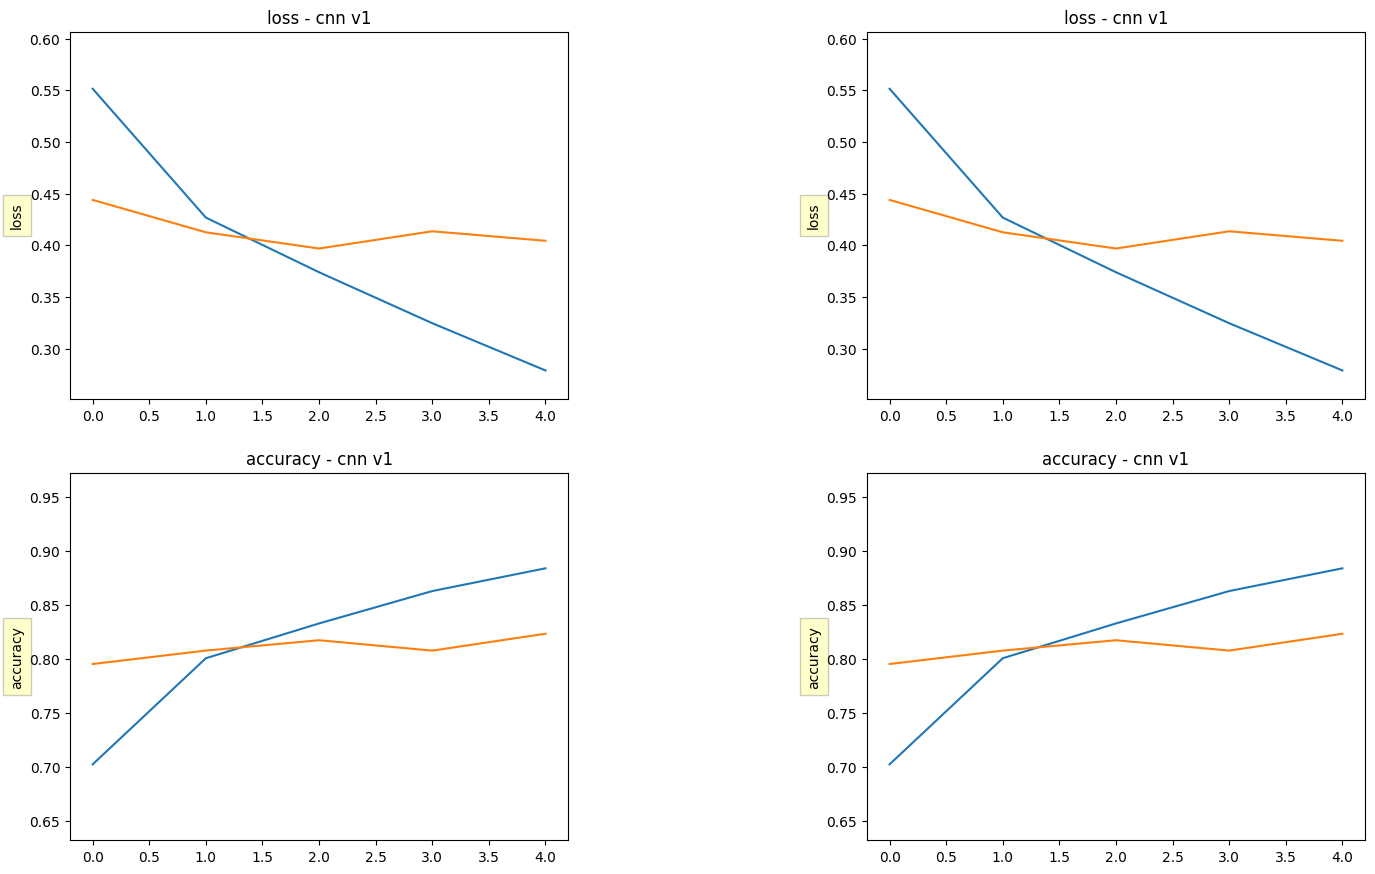

In [ ]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history,
          model_1_name='cnn v1',
          model_2_name='cnn v1')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'cnnExercise'></a>
### 3.2. CNN Exercise

A. The CNN model above is overfitting.  You can tell this because the training loss keeps going down while the validation loss is increasing. Can you make the CNN model overfit less? What parameter(s) might you change to make this model less likely to overfit? How good (or bad) can you make it get?

> Hint: think about all of the options you can vary, including:
* add/remove more hidden layers
* vary dropout rates and dimensions
* enable/disable retraining of embedding matrix
* change number of filters
* change kernel sizes of filters
* change the batch size
>
> For the option(s) you choose, do you think it will make the model more or less likely to overfit? Try it, does it work the way you expect?

Here is an example of the loss curve for a model that is extremely overfit:

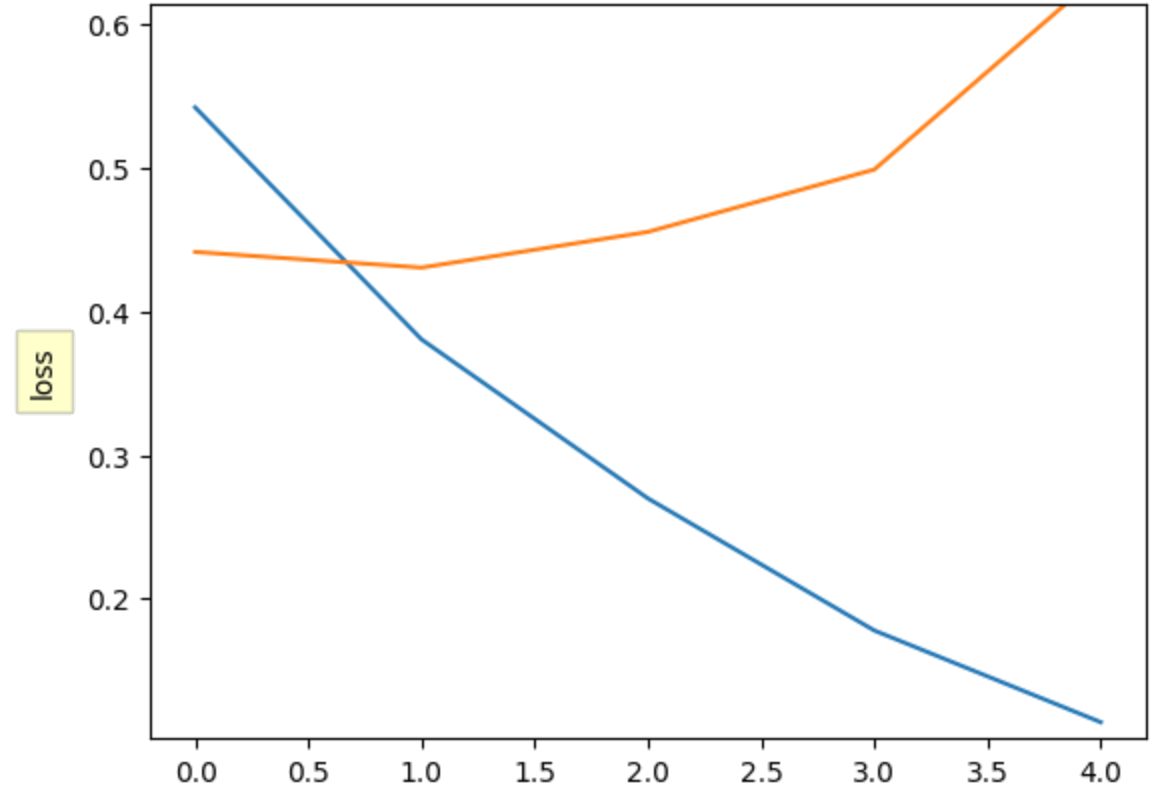

and here is an example of the loss curve where the model is converging and not overfitting:

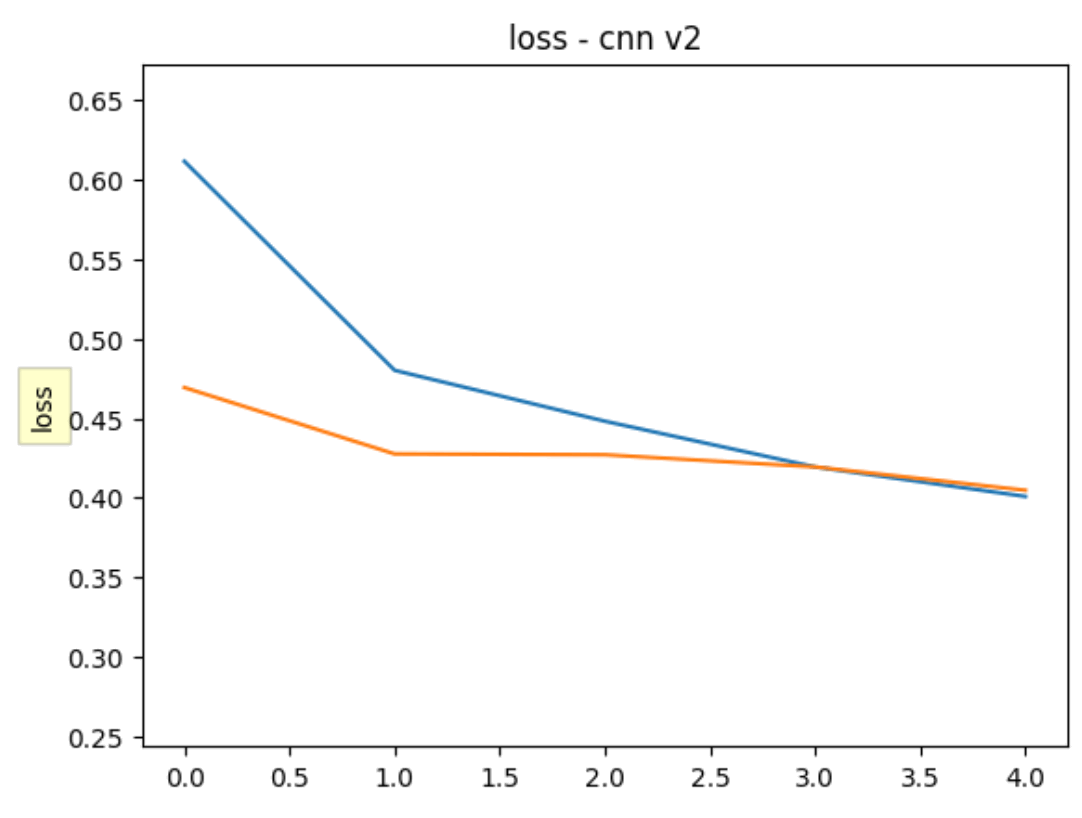


Your task is to fix the CNN model so that it is no longer overfit when you train it.  You should modify the specified hyperparameters until the model no longer overfits. We define your goal as a case where after each epoch, the loss and val_loss value is lower than the epoch before.  This will be reflected in the shape of the loss curves as shown above.  

In [34]:
# CNN model hyperparameters: Change these

### YOUR CODE HERE

num_filters = [32, 64]
kernel_sizes = [3, 5]
dense__layer_dims= [32]
dropout_rate = 0.6
embeddings_trainable = False
batch_size = 32
### END YOUR CODE

cnn_model2 = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims,
                            dropout_rate, embeddings_trainable)

cnn_history2 = cnn_model2.fit(train_input,
                              train_labels,
                              validation_data=(test_input, test_labels),
                              batch_size=batch_size,
                              epochs=5
                              )

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - accuracy: 0.5941 - loss: 0.6461 - val_accuracy: 0.7832 - val_loss: 0.4623
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - accuracy: 0.7695 - loss: 0.4830 - val_accuracy: 0.8012 - val_loss: 0.4368
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 71ms/step - accuracy: 0.7954 - loss: 0.4382 - val_accuracy: 0.8018 - val_loss: 0.4186
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - accuracy: 0.8218 - loss: 0.3975 - val_accuracy: 0.8118 - val_loss: 0.4134
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 93s 91ms/step - accuracy: 0.8296 - loss: 0.3828 - val_accuracy: 0.8128 - val_loss: 0.4094


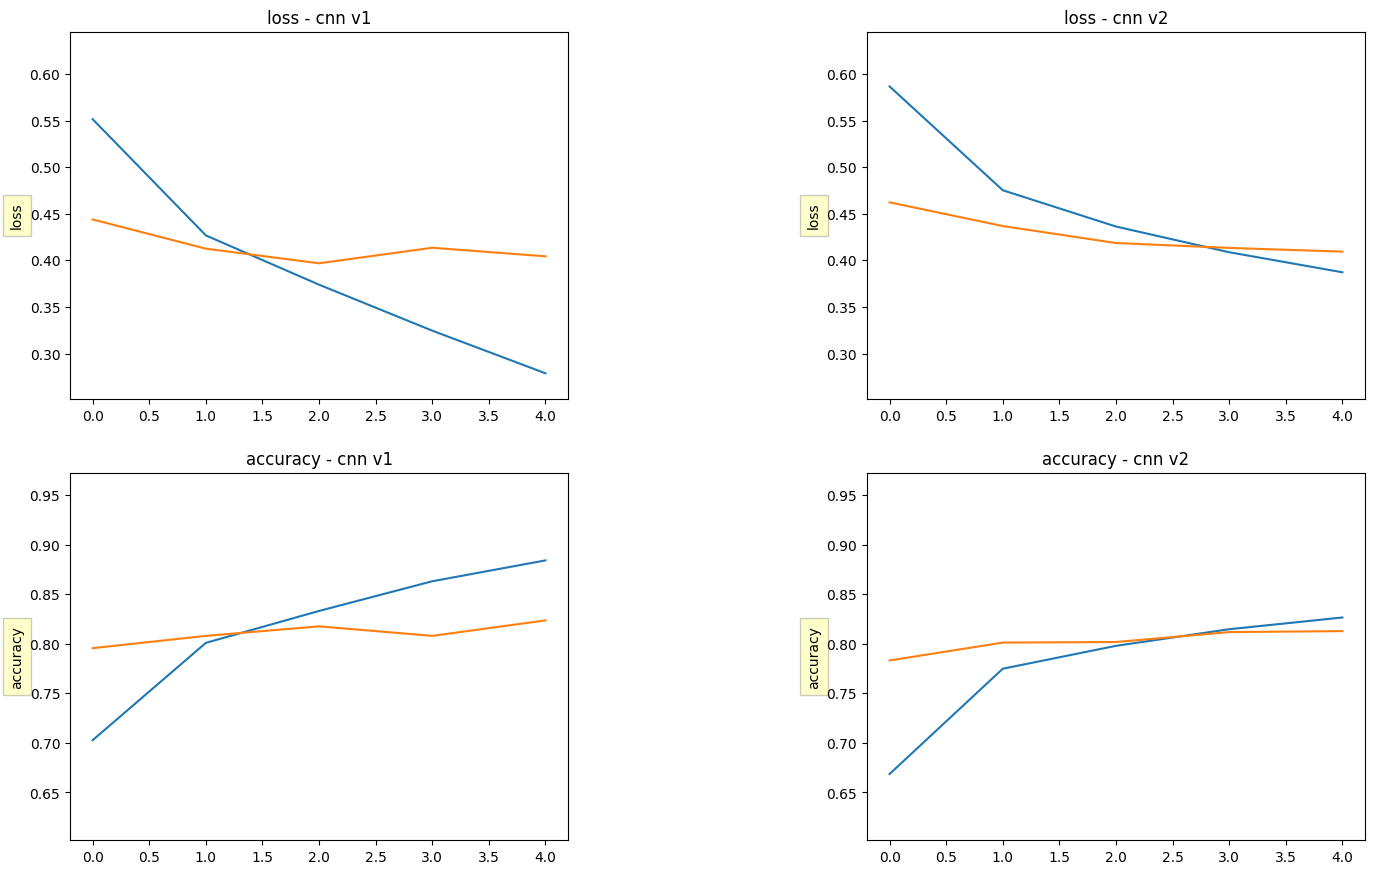

In [35]:
# Do the plots change how you'd expect?
# Did the runtime change (in the cells above)?

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          cnn_history,
          cnn_history2,
          model_1_name='cnn v1',
          model_2_name='cnn v2')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

 **QUESTION:**

1.a
What is the val_loss value you have after the 1st epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.b
What is the val_loss value you have after the 2nd epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.c
What is the val_loss value you have after the 3rd epoch of training?  Copy the value in the output to the answers file.


 **QUESTION:**

1.d
What is the val_loss value you have after the 4th epoch of training?  Copy the value in the output to the answers file.

 **QUESTION:**

1.e
What is the val_loss value you have after the 5th and final epoch of training.  Copy the value in the output to the answers file.


 **QUESTION:**

1.f
What values did you use for num_filters = [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.g
What values did you use for kernel_sizes = [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.h
What values did you use for dense__layer_dims= [] to stop the overfitting? Copy the values into the answers file.


 **QUESTION:**

1.i
What value did you use for dropout_rate = [] to stop the overfitting? Copy the value into the answers file.


 **QUESTION:**

1.j
What value did you use for embeddings_trainable = to stop the overfitting? Copy the value into the answers file.


 **QUESTION:**

1.k
What value did you use for batch_size = to stop the overfitting? Copy the value into the answers file.

You're done with this portion.  Continue on to the next notebook.